In [2]:
import pandas as pd
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt


loading df

In [3]:
offensive_tweets_df=pd.read_csv('./labeled_data.csv')


data cleaning

In [4]:

offensive_tweets_df.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'], axis=1, inplace=True)

def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"&amp;", "&", text) 
    text = re.sub(r"[^\w\s]", "", text) 
    text = text.strip()  
    return text.lower()



offensive_tweets_df['cleaned_tweet'] = offensive_tweets_df['tweet'].apply(preprocess_text)
offensive_tweets_df.head(10)

print(offensive_tweets_df['class'].value_counts()) # unbalanced df



class
1    19190
2     4163
0     1430
Name: count, dtype: int64


tokenization

In [5]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(offensive_tweets_df['cleaned_tweet'])
x = tokenizer.texts_to_sequences(offensive_tweets_df['cleaned_tweet'])

# Pad the sequences so that they have the same length
x = pad_sequences(x, maxlen=100)

y = offensive_tweets_df['class']
print(x)

[[   0    0    0 ...    5   52   54]
 [   0    0    0 ...    5  864  531]
 [   0    0    0 ... 1037   73   44]
 ...
 [   0    0    0 ...  349   30  293]
 [   0    0    0 ... 1990    6 1500]
 [   0    0    0 ...  177  113    1]]


preparing train and test sets

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)



In [7]:
from imblearn.combine import SMOTEENN
from tensorflow.keras.utils import to_categorical

# Initialize SMOTEENN (Synthetic Minority Over-sampling Technique + Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=42)

# Apply resampling to balance the dataset
X_resampled, y_resampled = smote_enn.fit_resample(x_train, y_train)

# Convert target labels to categorical format (one-hot encoding)
# This prevents the model from assigning higher importance to larger labels (e.g., 2 > 0)
y_train_categorical = to_categorical(y_resampled, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)


### comparing the balance between the sets before and after smoteenn

In [ ]:
unique_classes, counts = np.unique(y_train, return_counts=True)
print(f"class distribution y_train: {dict(zip(unique_classes, counts))}")

unique_classes, counts = np.unique(y_resampled, return_counts=True)
print(f"class distribution y_resampled: {dict(zip(unique_classes, counts))}")
print(X_resampled.shape,y_resampled.shape)

class distribution y_train: {0: 1003, 1: 13443, 2: 2902}
class distribution en y_resampled: {0: 12231, 1: 4695, 2: 10978}
(27904, 100) (27904,)


### preparing the sequential model

In [9]:


# Initialize the Sequential model
model = Sequential()

# Embedding layer: Converts tokens into dense vector representations
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))

# GRU layer (actually an LSTM in this case)
model.add(LSTM(128))

# Output layer: For multi-class classification (3 classes)
# Uses softmax activation for probability distribution across classes
model.add(Dense(3, activation='softmax'))

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Display model architecture summary
model.summary()

# Train the model using the resampled dataset
model.fit(X_resampled, y_train_categorical, epochs=10, batch_size=32)


c:\Users\57300\Desktop\presentacion ia\articulo\articulo_ia\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - loss: 0.9083
Epoch 2/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 80s 91ms/step - loss: 0.6398
Epoch 3/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 79s 91ms/step - loss: 0.4828
Epoch 4/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 78s 89ms/step - loss: 0.3579
Epoch 5/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 78s 89ms/step - loss: 0.2616
Epoch 6/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 78s 89ms/step - loss: 0.1796
Epoch 7/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - loss: 0.1132
Epoch 8/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 85s 97ms/step - loss: 0.0755
Epoch 9/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 79s 90ms/step - loss: 0.0468
Epoch 10/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 78s 90ms/step - loss: 0.0329


In [10]:

# predictions
y_pred = model.predict(x_test)

# Convert one-hot encoded predictions to labels
y_pred_labels = y_pred.argmax(axis=1)
y_test_labels = y_test_categorical.argmax(axis=1)
    
# get the performance  
print("accuracy:",accuracy_score(y_test_labels, y_pred_labels))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))


233/233 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step
accuracy: 0.6671149966375253
Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.43      0.19       427
           1       0.94      0.67      0.78      5747
           2       0.49      0.73      0.59      1261

    accuracy                           0.67      7435
   macro avg       0.52      0.61      0.52      7435
weighted avg       0.82      0.67      0.72      7435



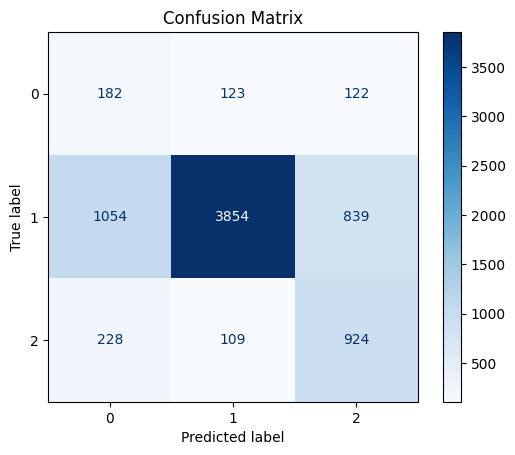

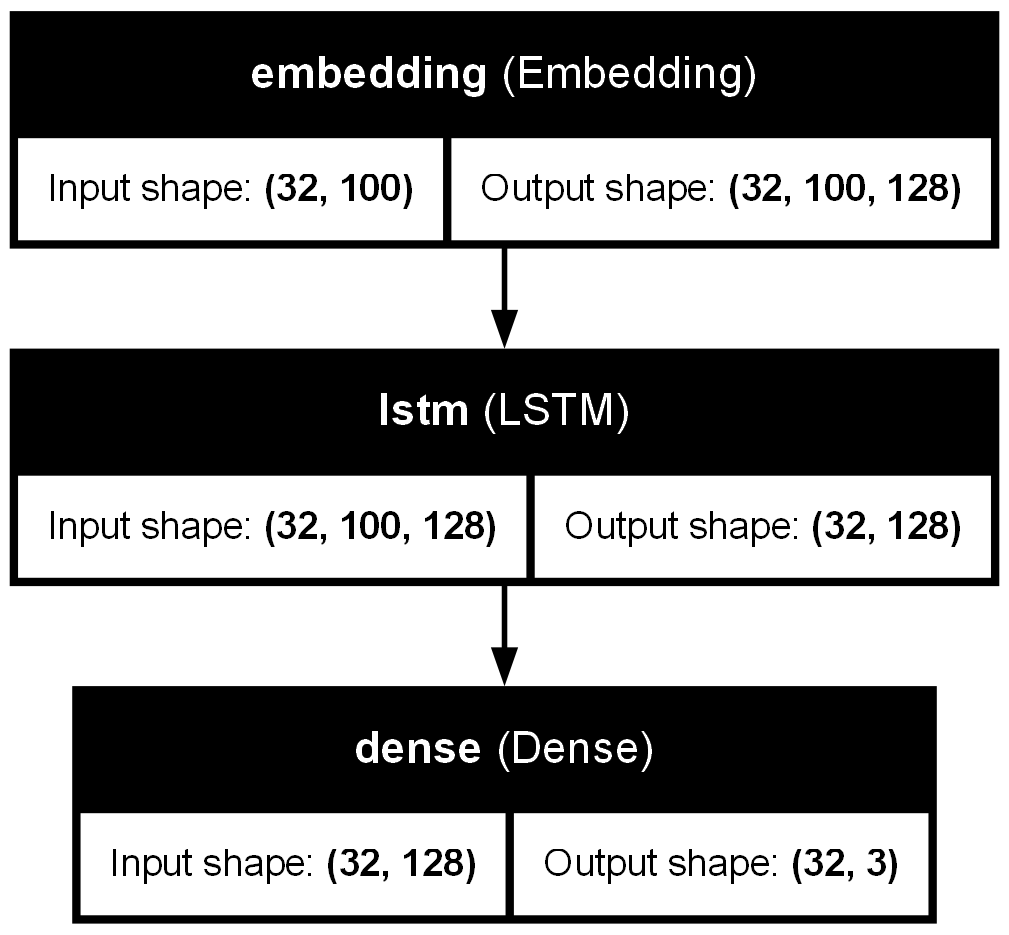

In [11]:


# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Create a more readable confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)  # Change 'Blues' to other styles like 'viridis' or 'coolwarm' if preferred

# Add title and display the plot
plt.title("Confusion Matrix")
plt.show()

# Generate a diagram of the model architecture
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)


In [12]:
model.save('model.h5')